In [2]:
########## Imports ##########

import numpy as np
import pandas as pd

# Représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
#!pip install Levenshtein
from Levenshtein import *
import pickle
import os

# Import the tokenizer of NLTK
import nltk

# problème avec version de tensorflow et protobuf : besoin d'installer cette version pour éviter l'erreur
#!pip install protobuf==3.20.3 --upgrade
import tensorflow as tf

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

# Nb de GPU disponibles
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Choix d'une palette de couleurs

sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
# palettes testées : 'Spectral', 'flare', 'twilight', 'husl', 'Set1', 'Set2', 'Set3'
#sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [4]:
########## Consignes ##########

# Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
# - un algorithme de type SIFT / ORB / SURF
# - un algorithme de type CNN Transfer Learning.
# Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources

In [5]:
########## Cours ##########

# Une image numérique est caractérisée par sa définition et sa résolution
# Définition = hauteur × largeur (en pixels)
# Résolution = nombre de pixels par unité de longueur de l'image analogique. Elle permet de mesurer la qualité de l'image obtenue après numérisation : plus la résolution est élevée, meilleure est la qualité de l'image

# 1 mégapixel = 1 million de pixels
# -> = définition (donc taille, pas forcément qualité)

In [6]:
########## Formats de fichiers ##########
# -> compression de l'image

# formats de compression sans perte de données -> PNG, TIFF...
# formats de compression avec perte de données -> JPEG

In [7]:
########## Import données csv ##########
# dossier data hors du dossier code pour ne pas l'importer dans github

df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [8]:
df.shape

(1050, 15)

In [9]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [11]:
########## Ajout des labels (catégories) ##########

In [12]:
########## Catégorie ##########
def get_category(row):
    match = re.search(r'(?:\w+\s+){2}(?=\>\>)', row['product_category_tree'])
    if match:
        result = match.group(0).strip()
        return result
    
df['category'] = df.apply(get_category, axis = 1)
df['category']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1050, dtype: object

In [13]:
# Dictionnaire key = catégorie et value = label num
category_mapping = {
    'Home Furnishing' : 0,
    'Baby Care' : 1,
    'Wrist Watches' : 2,
    'Festive Needs' : 3,
    'Tray Sets' : 4,
    'BFT Bulbs' : 5,
    'Personal Care' : 6,
    'Coffee Mugs' : 7,
    'Network Components' : 8,
    'Tablet Accessories' : 9,
    'Other' : 10,
    'Laptop Accessories' : 11,
    'Lunch Boxes' : 12,
    'Caffeine Bowls' : 13,
    'Water bottle' : 14,
    'Omic Sippers' : 15,
    'Pen Drives' : 16,
    'Kitchen Tools' : 17,
    'Bar Accessories' : 18,
    'Bar Glasses' : 19,
    'Idli Makers' : 20,
    'Craft Jugs' : 21,
    'Table Clocks' : 22,
    'Bhalaria Forks' : 23,
    'Kitchen Containers' : 24,
    'Computer Components' : 25
    }

df['category_num'] = df['category'].map(category_mapping)
df['category_num']

0       0.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
1045    1.0
1046    1.0
1047    1.0
1048    1.0
1049    1.0
Name: category_num, Length: 1050, dtype: float64

1050
Home Furnishing


ValueError: num must be an integer with 1 <= num <= 3, not 4

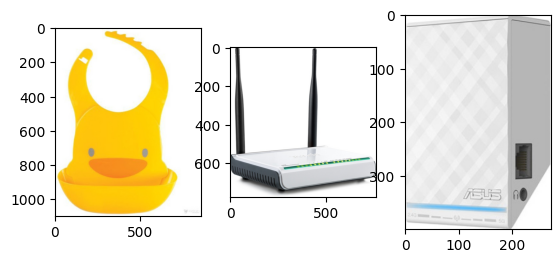

In [15]:
########## Affichage d'images par catégorie ##########
from os import listdir
from matplotlib.image import imread

path = "../data/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(df)) if df['category'][i]==name]
    return list_image_name

for name in df['category'].value_counts().index[:5]:
    print(name)
    # print("-------")
    for i in range(5):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [ ]:
########## Analyse des images ##########

In [ ]:
# test avec librairie Pillow

from PIL import Image

# Charger l'image
img = Image.open('../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg')

# Afficher l'image chargée
img.show()

# -> va ouvrir l'image dans une autre fenêtre

In [ ]:
# Récupérer et afficher la taille de l'image en pixels

w, h = img.size
print('Largeur : {} px, hauteur : {} px'.format(w, h))

# Afficher son mode de quantification
print('Format des pixels : {}'.format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20, 100))
print('Valeur du pixel situé en (20, 100) : {}'.format(px_value))

Largeur : 687 px, hauteur : 1162 px
Format des pixels : RGB
Valeur du pixel situé en (20, 100) : (255, 255, 255)


In [ ]:
import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print('Taille de la matrice de pixels : {}'.format(mat.shape))

Taille de la matrice de pixels : (1162, 687, 3)


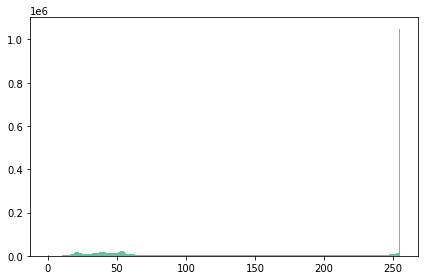

In [ ]:
##### Histogramme #####

# Charger l'image comme matrice de pixels
img = np.array(Image.open('../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg'))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins = range(256))
plt.tight_layout()
plt.show()

In [ ]:
# note -> lien "documentation" du cours -> erreur 404

# voir cours -> transformation d'images, extraction de features (bords, etc...)

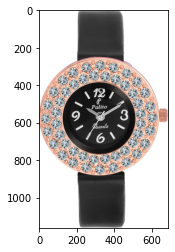

In [ ]:
from matplotlib.image import imread

# define filepath
filepath = '../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg'
# load image pixels
image = imread(filepath)
# plot raw pixel data
plt.imshow(image)

In [ ]:
df['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

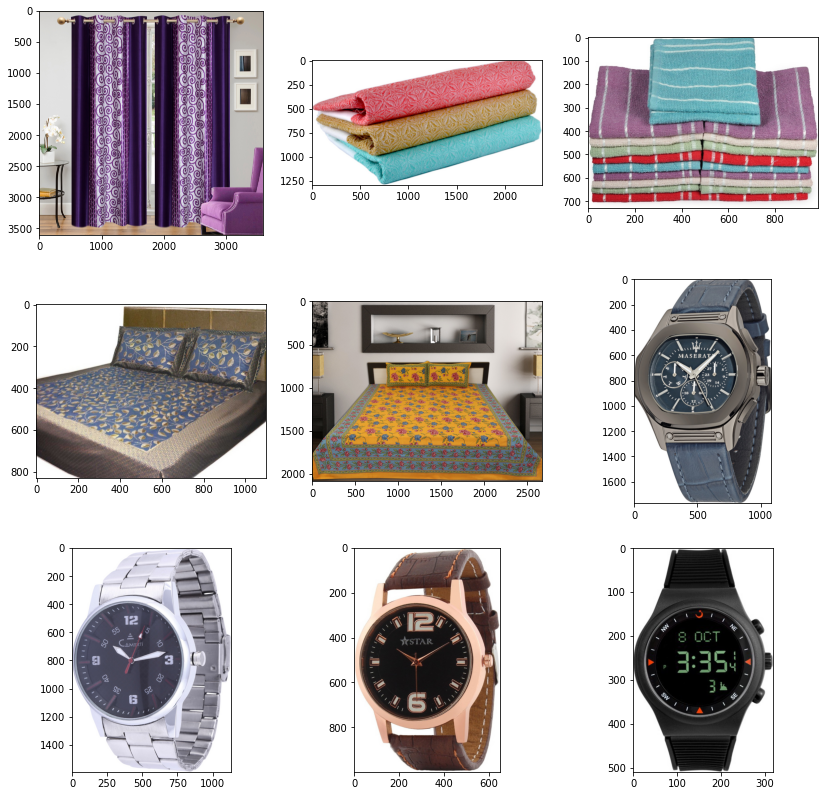

In [ ]:
# plot first few images
plt.figure(figsize = (14, 14))
for i in range(9):
    try:
        # define subplot
        plt.subplot(330 + 1 + i)
        # define filename
        filename = df['image'][i]
        # load image pixels
        image = imread('../data/Images/' + filename)
        # plot raw pixel data
        plt.imshow(image)
    except:
        print(f'Erreur : no such file or directory: {filename}')
## show the figure
plt.show()

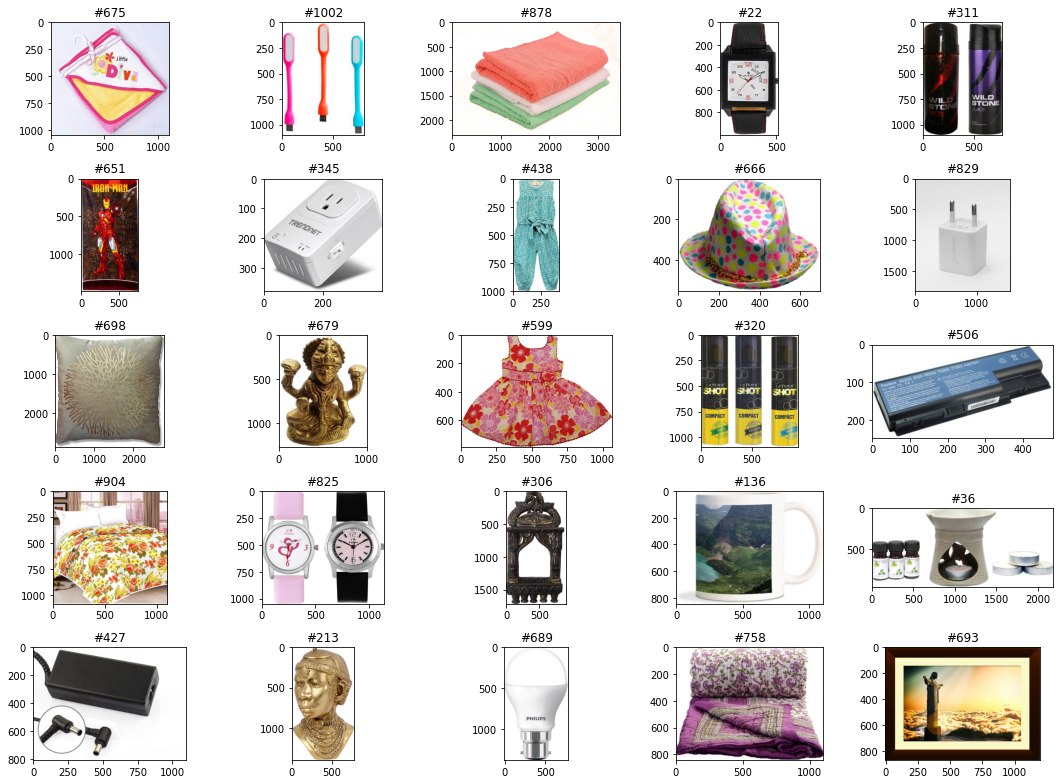

In [ ]:
# plot 25 images au hasard
plt.figure(figsize = (15, 11))

for i in range(0, 25):
    plt.subplot(5, 5, 1 + i)
    x = int(np.random.randint(0, 1050, 1))
    image = imread('../data/Images/' + df['image'][x])
    plt.title(f'#{x}')
    plt.imshow(image)

plt.tight_layout()
plt.show()

### SIFT

In [ ]:
########## Algorithme SIFT #########

# = Scale-invariant feature transform
# méthode permettant d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs.

# descripteur = vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images

# L'algorithme SIFT se divise en plusieurs étapes :
# - Détection : création de l'espace des échelles, calcul des "DoG", localisation des points d'intérêt
# - Description : assignation d'orientation, création des descripteurs


# https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

# TO DO -> regarder le webinaire


In [ ]:
#pip install cv2

In [ ]:
#pip install opencv-python

In [ ]:
import cv2 as cv

img = cv.imread('../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg')
gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray, None)
img = cv.drawKeypoints(gray, kp, img)
cv.imwrite('sift_keypoints.jpg', img)

True

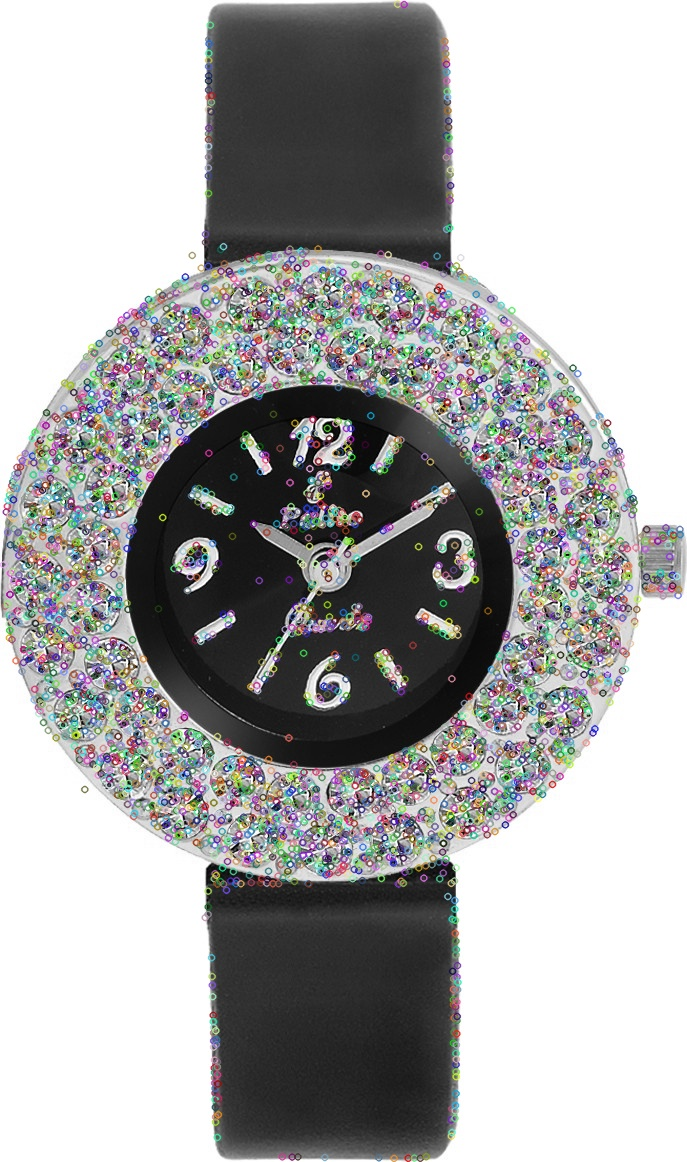

In [ ]:
from IPython import display
display.Image("sift_keypoints.jpg", width = 300)

In [ ]:
img = cv.drawKeypoints(gray, kp, img, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints2.jpg', img)

True

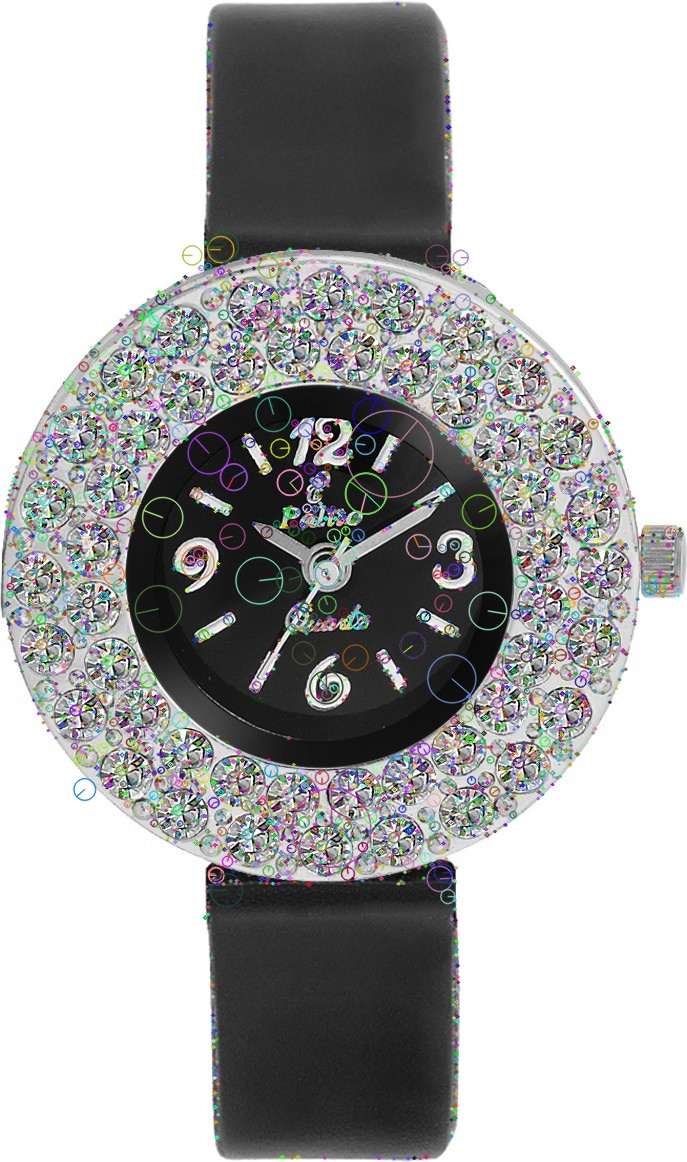

In [ ]:
from IPython import display
display.Image("sift_keypoints2.jpg", width = 300)

In [ ]:
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

In [ ]:
########## cf code webinar ##########

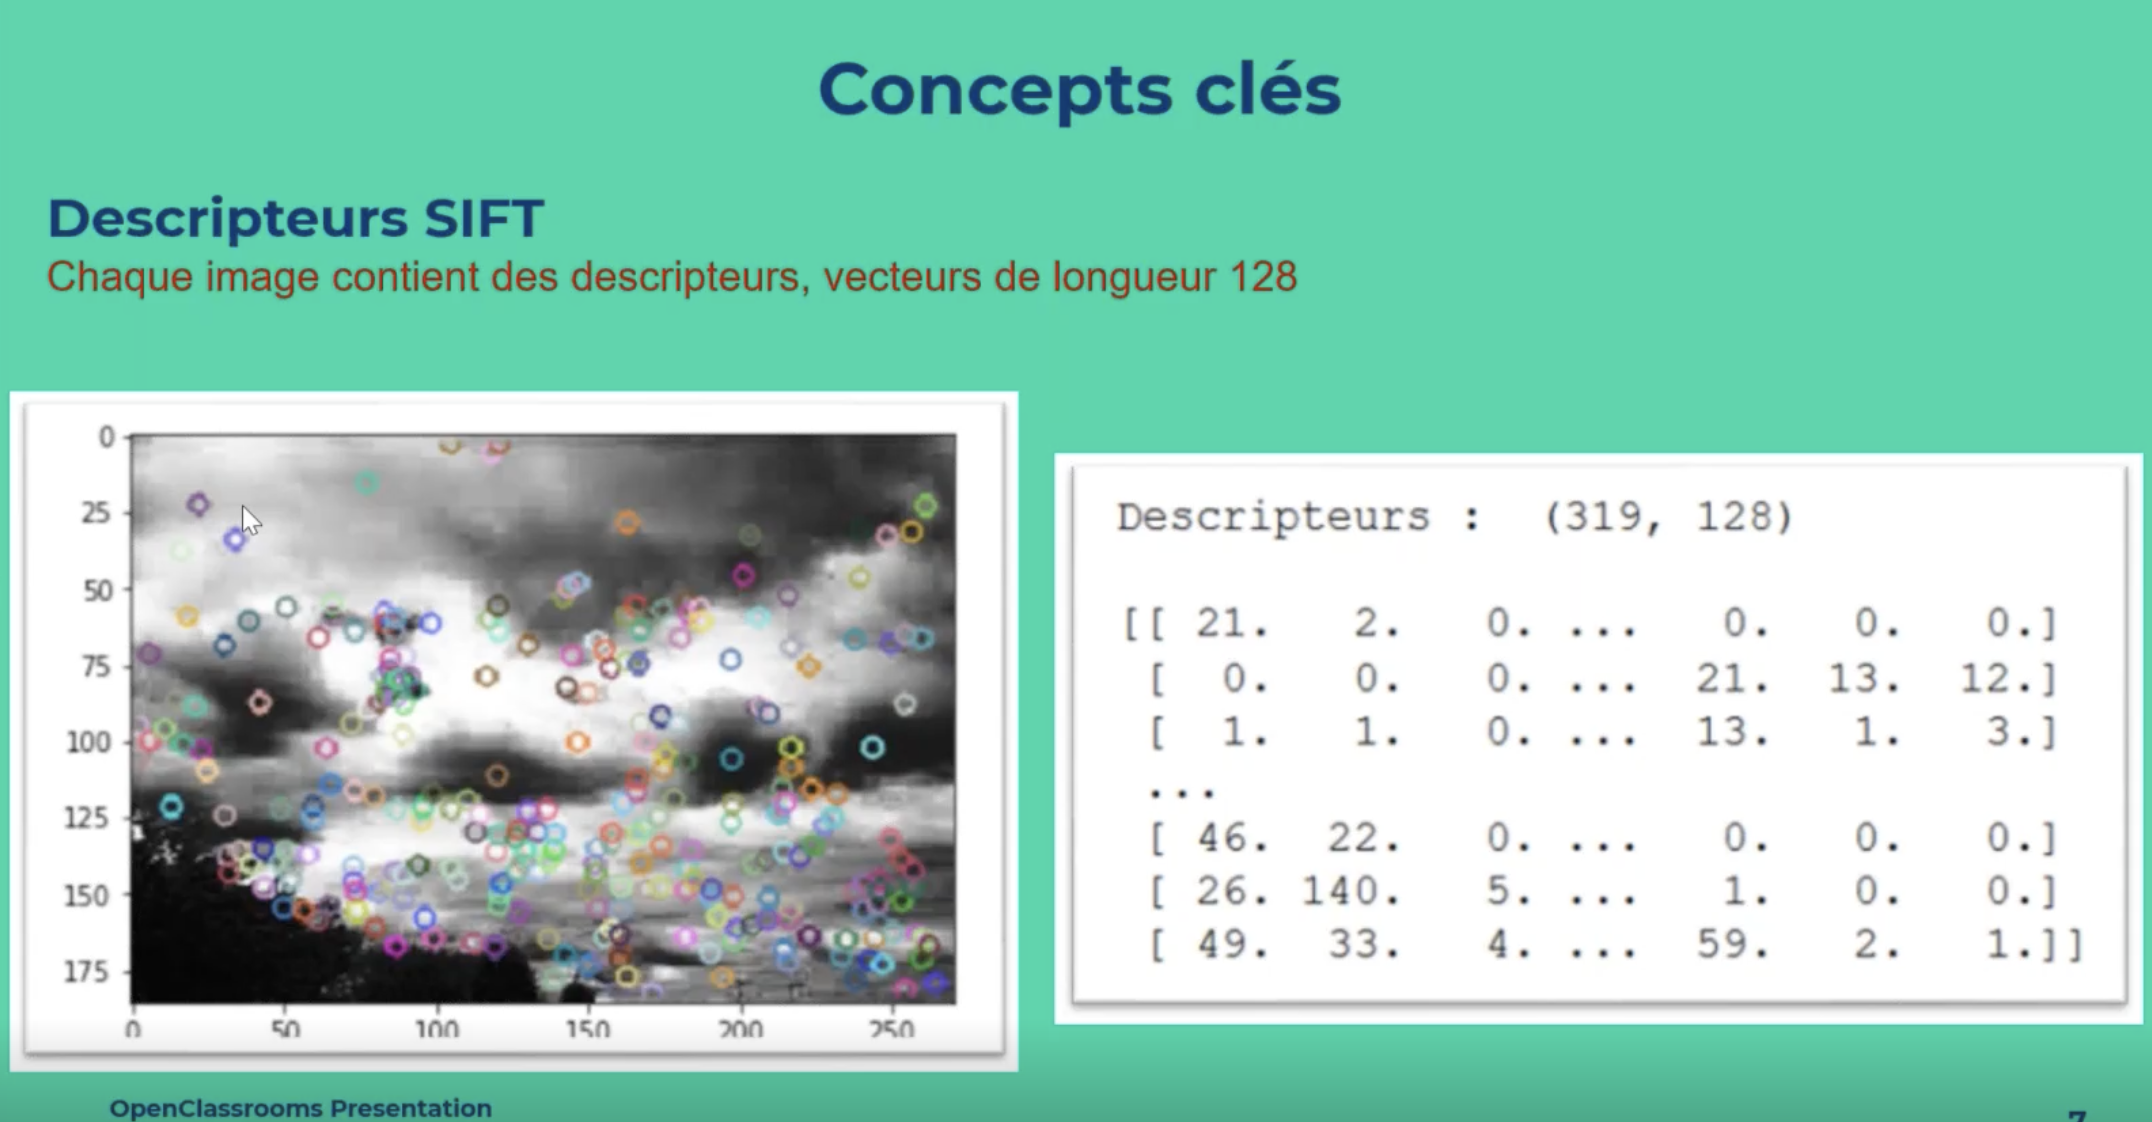

In [ ]:
from IPython import display
display.Image("Capture d’écran 2024-01-30 à 13.42.56.png", width = 600)

In [ ]:
# petits ronds -> features (descripteurs)
# ici 319 descripteurs pour une seule image

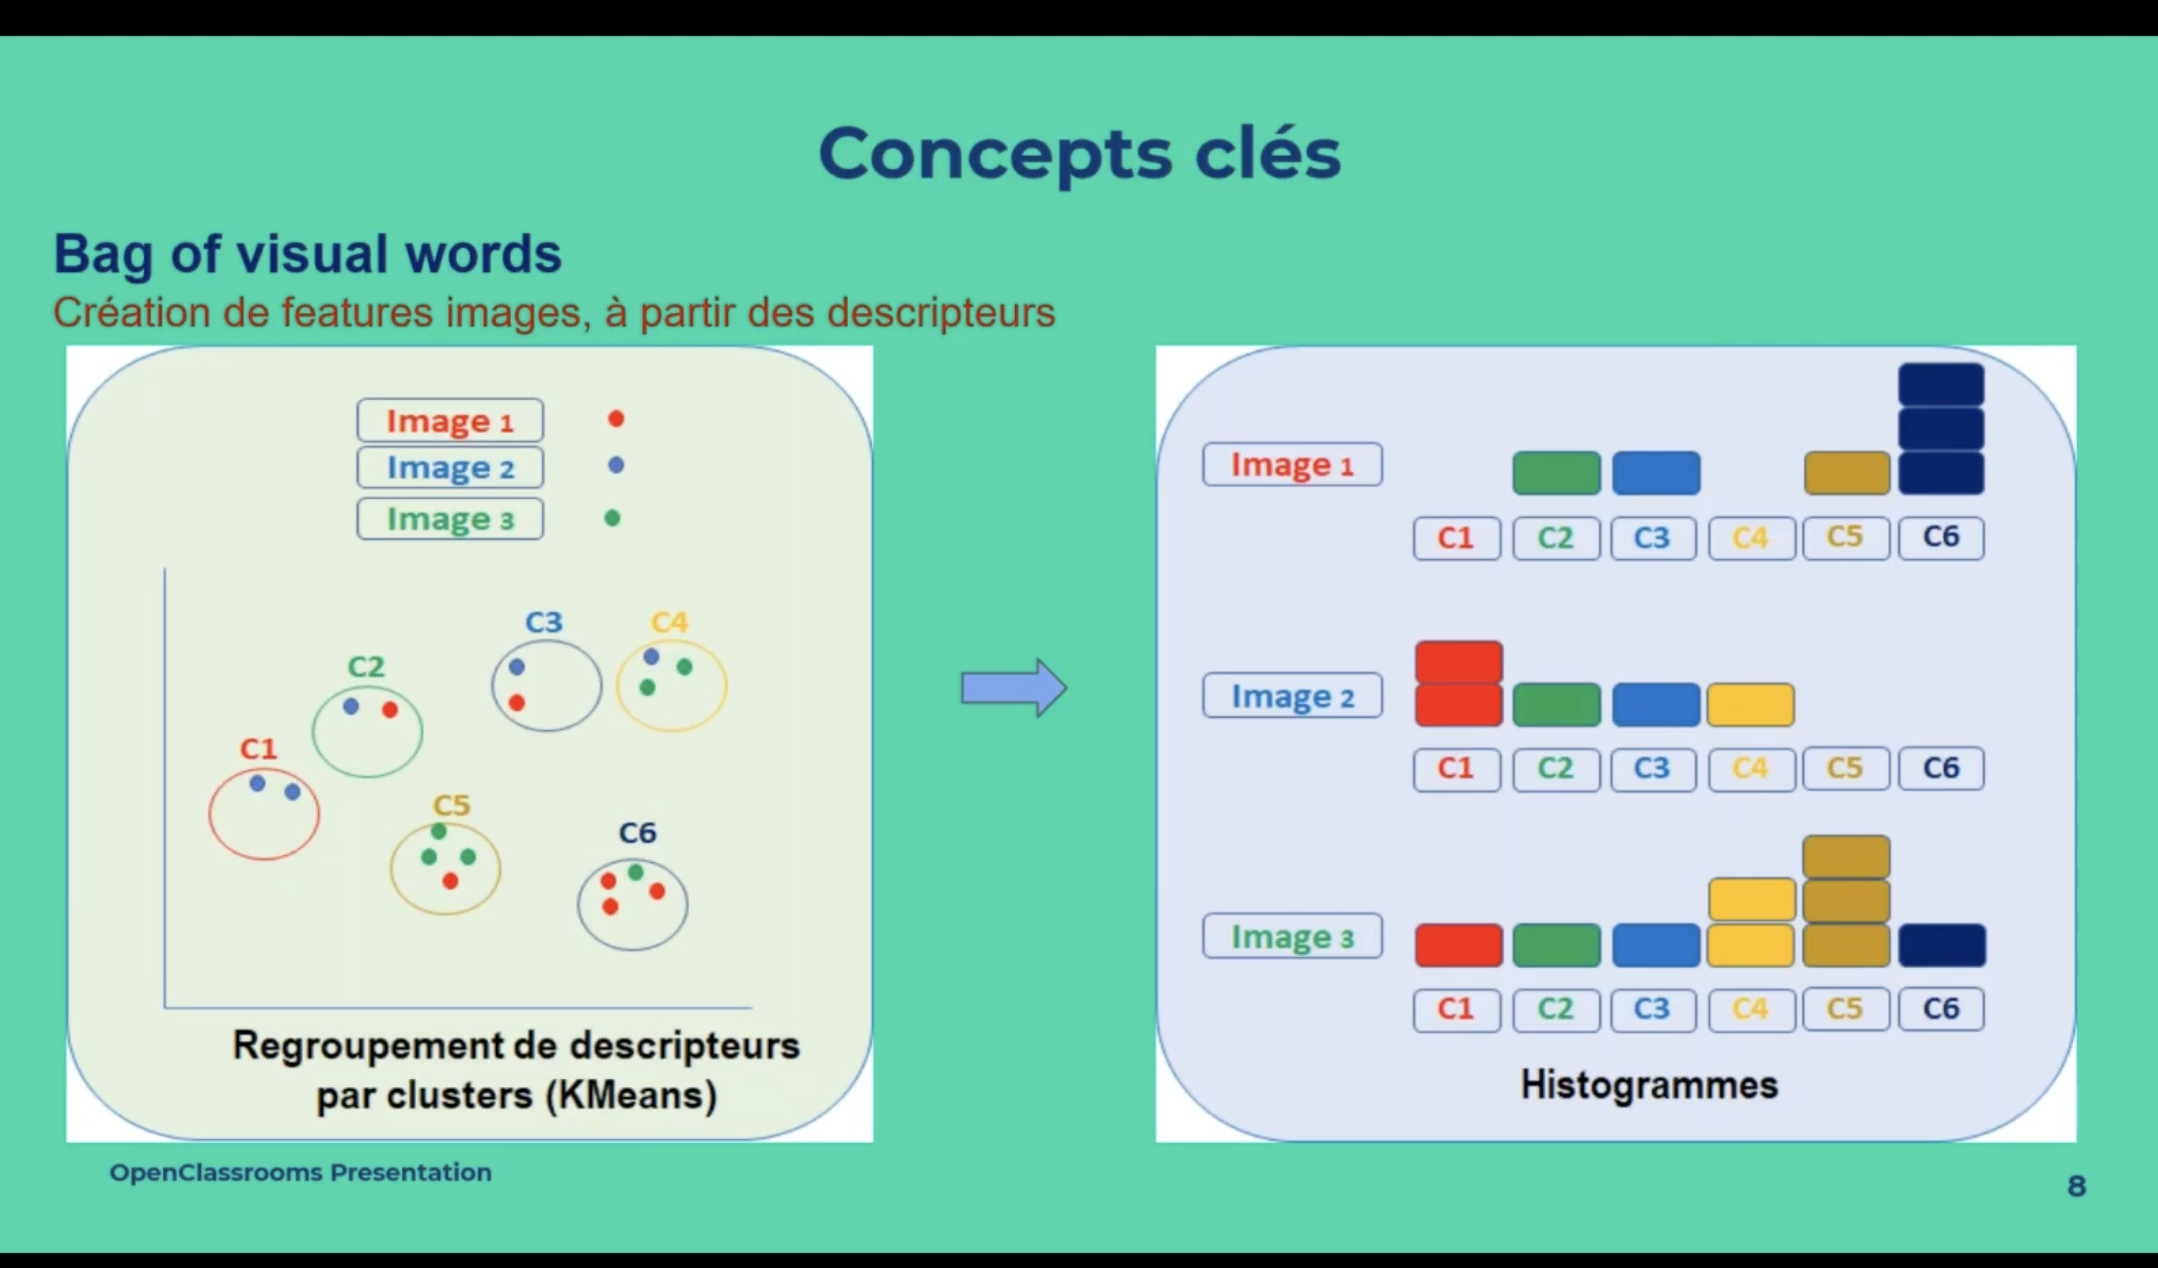

In [ ]:
from IPython import display
display.Image("Capture d’écran 2024-01-30 à 13.36.39.png", width = 600)

In [ ]:
# puis bag of visual words
# -> regroupements en clusters de descripteurs qui sont proches entre eux avec kmeans ou équivalent puis on compte combien il y a de descripteurs par clusters et par image
# ici C1, C2, C3... = clusters

In [ ]:
# démarche génnérale : 
# 1 - création de descripteurs par image et pour toutes les images
# 2 - création de clusters de descripteurs
# 3 - création d'histogramme par image
# 4 - réduction de dimension PCA / T-SNE
# 5 - analyse visuelle : affichage T-SNE selon catégories d'images
# 6 - analyses mesures : similarité entre catégories et clusters

In [ ]:
# SIFT is a patented algorithm, hence not available in each open-cv version -> install opencv and its contrib part simultaneously
#!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
#!pip install opencv-contrib-python

In [ ]:
import cv2

path = "../data/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


[ WARN:0@12.645] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


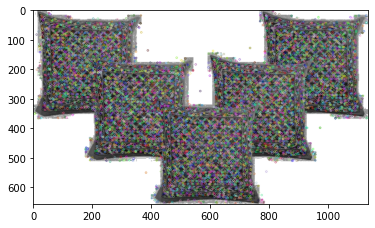

Descripteurs :  (11002, 128)

[[  0.   0.   2. ...   2.   2.  16.]
 [ 27.   2.   2. ...   0.   4.  33.]
 [139.  44.   5. ...   3.   0.   0.]
 ...
 [ 13.  21.   1. ...   0.   1.   4.]
 [  1.   3.   3. ...   0.   0.   0.]
 [ 29.  27.  11. ...   4.  26.   3.]]


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path + list_photos[1], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [ ]:
########## Création des descripteurs pour chaque image ##########
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num % 100 == 0 :
        print(image_num)
    image = cv2.imread(path + list_photos[image_num], 0) # convert in gray
    res = cv2.equalizeHist(image) # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype = 'object')
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis = 0)

print('Nombre de descripteurs : ', sift_keypoints_all.shape)

duration1 = time.time()-temps1
print('temps de traitement SIFT descriptor : ', '%15.2f' % duration1, 'secondes')

0
100
200
300
400
500
600
700
800
900
1000
Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           250.90 secondes


In [ ]:
# tuner paramètres -> choix nb de descripteurs

In [ ]:
# Création des clusters de descripteurs

from sklearn import cluster, metrics

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             7.92 secondes


In [ ]:
# Création des features des images
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.68 secondes


In [ ]:
# Réduction de dimension - PCA
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


In [ ]:
# Réduction de dimension - TSNE

from sklearn import manifold, decomposition

tsne = manifold.TSNE(
    n_components = 2,
    perplexity = 30,
    n_iter = 2000,
    init = 'random',
    random_state = 6
    )
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['category']
print(df_tsne.shape)

(1050, 3)


In [ ]:
sift_keypoints_by_img

array([array([[51.,  9.,  7., ...,  2.,  1., 57.],
              [11.,  1.,  0., ...,  0.,  0.,  9.],
              [21.,  0.,  0., ...,  1.,  0., 15.],
              ...,
              [48.,  2.,  0., ...,  2.,  0.,  0.],
              [43.,  3.,  0., ..., 15.,  1.,  0.],
              [25.,  2.,  0., ...,  1.,  1.,  1.]], dtype=float32),
       array([[ 29.,  27.,  11., ...,   4.,  26.,   3.],
              [ 35.,  50.,   4., ...,   0., 115., 112.],
              [  0.,   0.,  12., ...,   0.,   0.,   0.],
              ...,
              [ 37.,   1.,   0., ...,   0.,   0.,  50.],
              [ 25.,   1.,   1., ...,  17.,   3.,   4.],
              [  5.,   5.,   4., ...,   1.,   0.,   0.]], dtype=float32),
       array([[  0.,  16., 123., ...,   0.,   0.,   6.],
              [  0.,   9.,  50., ...,   0.,   0.,   1.],
              [  0.,   0.,   0., ...,   0.,   0.,   1.],
              ...,
              [  1.,   0.,   0., ...,  18.,   6.,  12.],
              [ 26.,   5.,  25., 

In [ ]:
# fin -> j'obtiens un vecteur qui va décrire mon image
# utiliser ces vecteurs pour classif
# faire classification puis comparer avec résultats cnn
# faire un kmeans
# faire visualisation des images en 2D (graph tsne)
# calculer un score (ARI score)

# normalement on devrait être amenés à dire que sift/orb/surf -> anciennes méthodes moins performantes vs CNN, cependant ici pas vraiment une différence

### CNN

In [ ]:
########## Convolutional Neural Network (CNN) ##########

# = réseaux de neurones convolutifs
# = modèles de programmation puissants permettant notamment la reconnaissance d’images en attribuant automatiquement à chaque image fournie en entrée, 
# une étiquette correspondant à sa classe d’appartenance

# Utilisation :
# réseaux convolutifs apprennent plus rapidement et ont un meilleur taux d’erreur. Dans une moindre mesure, on les utilise aussi pour l’analyse vidéo
# Ce type de réseau est aussi utilisé pour le traitement naturel du langage
# utilisation pour les logiciels de jeu de Go ou de jeu d'échecs

# Explication :
# Les CNN désignent une sous-catégorie de réseaux de neurones et sont à ce jour un des modèles de classification d’images réputés être les plus performant
# Leur mode de fonctionnement est à première vue simple : l’utilisateur fournit en entrée une image sous la forme d’une matrice de pixels
# Celle-ci dispose de 3 dimensions :
# - Deux dimensions pour une image en niveaux de gris.
# - Une troisième dimension, de profondeur 3 pour représenter les couleurs fondamentales (Rouge, Vert, Bleu).

# Contrairement à un modèle MLP (Multi Layers Perceptron) classique qui ne contient qu’une partie classification, l’architecture du Convolutional Neural Network 
# dispose en amont d’une partie convolutive et comporte par conséquent deux parties bien distinctes :
# -- Une partie convolutive :
#       Son objectif final est d’extraire des caractéristiques propres à chaque image en les compressant de façon à réduire leur taille initiale.
#       En résumé, l’image fournie en entrée passe à travers une succession de filtres, créant par la même occasion de nouvelles images appelées cartes de convolutions. 
#       Enfin, les cartes de convolutions obtenues sont concaténées dans un vecteur de caractéristiques appelé code CNN.
# -- Une partie classification :
#       Le code CNN obtenu en sortie de la partie convolutive est fourni en entrée dans une deuxième partie, constituée de couches entièrement connectées appelées
#       perceptron multicouche (MLP pour Multi Layers Perceptron). Le rôle de cette partie est de combiner les caractéristiques du code CNN afin de classer l’image.

# https://datascientest.com/convolutional-neural-network#:~:text=Les%20CNN%20d%C3%A9signent%20une%20sous,d'une%20matrice%20de%20pixels.

display.Image('General-structure-of-CNN-for-image-classification.ppm', width = 600)


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
import string
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from glob import glob

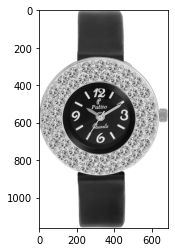

In [ ]:
# split en train / test

# Load an image train
img = load_img('../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg',grayscale = True)
x = img_to_array(img)  # this is a Numpy array with shape (260, 400, 1)
x = x.reshape((x.shape[:2])) # this is a Numpy array with shape (260, 400)

# Display it
import matplotlib.pyplot as plt
plt.imshow(x/255., cmap='gray')
plt.show()

In [ ]:
globbed = glob('../data/Images/*.jpg')
globbed

['../data/Images/aa68675f50a0551b8dadb954017a50a1.jpg',
 '../data/Images/037c2402fee39fbc80433935711d1383.jpg',
 '../data/Images/42643c1c9403f67921a18654bcf45ead.jpg',
 '../data/Images/53f4bc7d7321f5c41de6b86e41f13e80.jpg',
 '../data/Images/b144a363c107c7bdd91f32d6e28ba6f2.jpg',
 '../data/Images/db3e2eeb4fe90d4755f2911d661eae95.jpg',
 '../data/Images/9a9402ad55d079c86c302521816b7b0e.jpg',
 '../data/Images/42a8fef62716772c391fbdd148cc9c16.jpg',
 '../data/Images/503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '../data/Images/42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '../data/Images/9c4ab8ab059c912090c83cb0818e7f1c.jpg',
 '../data/Images/f2fa99bfaa4aa65a2bd53337e140f949.jpg',
 '../data/Images/a618354ba17cff64826558d81afc77ab.jpg',
 '../data/Images/c063d07d78a55a21bf6c0e7c8ae46a6d.jpg',
 '../data/Images/e99d9abb115a9bd580bcccf9ff4d4881.jpg',
 '../data/Images/1d829e0eac91d7e85cdd6d581c363360.jpg',
 '../data/Images/5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '../data/Images/06749cbff1487f470438823f6952cfd

In [ ]:
len(globbed)

1050

In [ ]:
def plot_images(number_of_images, globbed):
    shapes = []
    plt.figure(figsize = (13, 13))
    for i in range(number_of_images):
        plt.subplot(5, 5, i+1)
        image = imread(globbed[random.randint(0, len(globbed)-1)])
        plt.imshow(image)
        shapes.append(image.shape)
    plt.show()
    return shapes

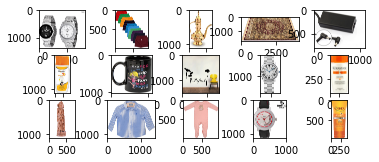

[(1380, 1672, 3),
 (1000, 895, 3),
 (1100, 682, 3),
 (1741, 4137, 3),
 (807, 1100, 3),
 (1100, 443, 3),
 (1015, 1100, 3),
 (1500, 1500, 3),
 (1775, 936, 3),
 (400, 196, 3),
 (1100, 757, 3),
 (1120, 1431, 3),
 (1000, 946, 3),
 (1129, 1002, 3),
 (956, 427, 3)]

In [ ]:
plot_images(15, globbed)

In [ ]:
df['category'].unique()

array(['Home Furnishing', 'Baby Care', 'Wrist Watches', 'Festive Needs',
       'Tray Sets', 'BFT Bulbs', 'Personal Care', 'Coffee Mugs',
       'Network Components', 'Tablet Accessories', None,
       'Laptop Accessories', 'Lunch Boxes', 'Caffeine Bowls',
       'Water bottle', 'Language Learning', 'Omic Sippers',
       'Computer Peripherals', 'Pen Drives', 'Kitchen Tools',
       'Bar Accessories', 'Bar Glasses', 'Idli Makers', 'Cookware Pots',
       'Home Cleaning', 'Computer Components', 'Craft Jugs',
       'Table Clocks', 'Bhalaria Forks', 'Kitchen Containers'],
      dtype=object)

In [ ]:
len(globbed)

1050

In [ ]:
# split en train / test
from sklearn.model_selection import train_test_split

# split train dataset into train, validation and test sets
X_train, X_text, y_train, y_test = train_test_split(sift_keypoints_by_img, df['category_num'], random_state = 0, test_size = 0.3)
X_val, X_text, y_val, y_test = train_test_split(X_text, y_test, random_state = 0, test_size = 0.5)

In [ ]:
X_train[0]

array([[18.,  3.,  6., ..., 42., 15.,  5.],
       [ 1., 10., 35., ...,  9.,  5.,  3.],
       [ 2.,  2.,  2., ...,  2.,  2.,  8.],
       ...,
       [17.,  5., 62., ..., 61., 19.,  5.],
       [ 0., 43., 40., ..., 35., 55., 41.],
       [22., 49., 64., ..., 51., 42.,  6.]], dtype=float32)

In [ ]:
X_train.shape

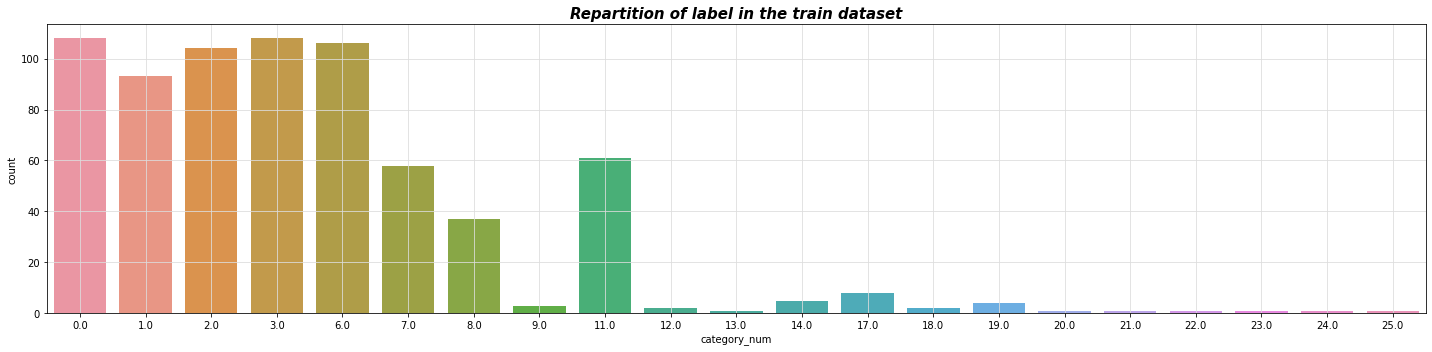

In [ ]:
# Is the train dataset unbalanced  ?
plt.figure(figsize = (20, 5))
sns.countplot(y_train)
plt.title('Repartition of label in the train dataset', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.tight_layout()
plt.show()

In [ ]:
X_text

array([array([[ 0.,  0.,  2., ...,  1.,  0.,  0.],
              [ 0.,  0.,  2., ...,  0.,  0.,  1.],
              [ 8., 20.,  4., ...,  0.,  0.,  0.],
              ...,
              [ 6., 11., 10., ...,  3., 13., 28.],
              [ 0.,  2., 12., ..., 29., 19., 18.],
              [33.,  4.,  0., ...,  0.,  0.,  0.]], dtype=float32),
       array([[  0.,   0.,   0., ...,  10.,  39., 111.],
              [  0.,   0.,   4., ...,   5.,   2.,   4.],
              [ 31.,  17.,   2., ...,  13.,   5.,  13.],
              ...,
              [ 14.,   5.,   3., ...,  40.,  85.,   2.],
              [ 49., 112.,   1., ...,  21., 123.,  29.],
              [  9.,  43.,  57., ...,   0.,   0.,   4.]], dtype=float32),
       array([[ 93.,   0.,   0., ...,   0.,   0.,   0.],
              [  2.,   1.,   0., ...,   0.,   5.,   4.],
              [ 41., 128.,  26., ...,   0.,   0.,  10.],
              ...,
              [  1.,   0.,   0., ...,   1.,   0.,   0.],
              [  0.,   2.,  11., 

In [ ]:
# use data generator to train the CNN
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    horizontal_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest'
    )

X_test = X_text/255

# transforming the labels (dummyfying) -> pas besoin vu que j'ai déjà fait ça manuellement avec le dictionnaire des catégories
#y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# CNN building
model = Sequential()

model.add(Conv2D(filters = 256, kernel_size = (5, 5), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 128, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation = 'softmax'))

2024-02-02 14:27:32.607821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 14:27:32.608923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       6656      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       819328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          204864    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [ ]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [ ]:
model.fit(train_datagen.flow(X_train, y_train, batch_size = 300), validation_data = (X_test, y_test), epochs = 40)

In [ ]:
y_pred = model.predict(X_test)

y_pred2 = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
y_test2 = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

In [ ]:
# Matrice de confusion
plt.figure(figsize = (15, 15))
sns.heatmap(confusion_matrix(y_test2, y_pred2), annot = True, cbar = False, cmap = 'Blues', annot_kws = {'size' : 8})
plt.xlabel('Predicted', fontdict = {'size': 20})
plt.ylabel('True', fontdict = {'size': 20})
plt.title('Confusion Matrix', fontdict = {'size': 20,'color':'Blue'})
plt.show()

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(10):
    ind = np.random.randint(0, len(X_test))
    plt.subplot(5, 2, i+1)
    plt.imshow(X_test[ind].reshape(28,28), cmap = 'gray')
    plt.title('True : {} , Predicted : {} with {} % of probabilities '.format(category_mapping[y_test2[ind]], category_mapping[y_pred2[ind]], round(y_pred[ind][y_pred2[ind]]*100, 2)))
plt.show()

In [ ]:
# faire aussi TSNE, score ARI etc... même démarche que pour sift
# ne pas entrainer le modèle, prendre le modèle pré entrainé et seulement utiliser ça et faire ma feature extraction

In [ ]:
# et ensuite -> partie classification supervisée sur images 
# en ouverture/ conclusion dire que pertinence de ma classification supervisée pourrait être améliorée en ajoutant données textes

#### Copie notebook du cours

In [36]:
# modèle pré entrainé du cours -> copie et adaptation du notebook du cours

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
from sklearn import preprocessing

# faire dataframe avec path to image, catégorie et catégorie normalisée

list_labels = df['category'].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Wrist Watches',
 'Festive Needs',
 'Tray Sets',
 'BFT Bulbs',
 'Personal Care',
 'Coffee Mugs',
 'Network Components',
 'Tablet Accessories',
 None,
 'Laptop Accessories',
 'Lunch Boxes',
 'Caffeine Bowls',
 'Water bottle',
 'Language Learning',
 'Omic Sippers',
 'Computer Peripherals',
 'Pen Drives',
 'Kitchen Tools',
 'Bar Accessories',
 'Bar Glasses',
 'Idli Makers',
 'Cookware Pots',
 'Home Cleaning',
 'Computer Components',
 'Craft Jugs',
 'Table Clocks',
 'Bhalaria Forks',
 'Kitchen Containers']

In [30]:
data_path = glob('../data/Images/*.jpg')[:700]
data_test_path = glob('../data/Images/*.jpg')[700:]

# adapter le code -> celui du cours va extraire les classes des noms des images - ici pas besoin, on a déja le csv avec les images et les catégories
# simplifier notre df pour ne garder que les 3 colonnes

In [14]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [15]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'category',
       'category_num'],
      dtype='object')

In [16]:
data = df[['image', 'category', 'category_num']]

In [19]:
# groupby par catégorie pour voir si données balancées ou non
data.groupby('category').count()

image  category_num
category                                 
BFT Bulbs                 1             1
Baby Care               150           150
Bar Accessories           3             3
Bar Glasses               5             5
Bhalaria Forks            1             1
Caffeine Bowls            1             1
Coffee Mugs              74            74
Computer Components       2             2
Computer Peripherals      4             0
Cookware Pots             1             0
Craft Jugs                1             1
Festive Needs           150           150
Home Cleaning             1             0
Home Furnishing         150           150
Idli Makers               1             1
Kitchen Containers        1             1
Kitchen Tools            14            14
Language Learning         1             0
Laptop Accessories       87            87
Lunch Boxes               2             2
Network Components       49            49
Omic Sippers              1             1
Pen Drives                2             2
Personal Care           150           150
Table Clocks              1             1
Tablet Accessories        3             3
Tray Sets                 1             1
Water bottle              7             7
Wrist Watches           149           149

In [29]:
# créer colonne image_path
data['image_path'] = '../data/Images/' + data['image']

In [28]:
data['image'][0]

'55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [30]:
data['image_path'][0]

'../data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [33]:
len(list_labels)

30

Home Furnishing


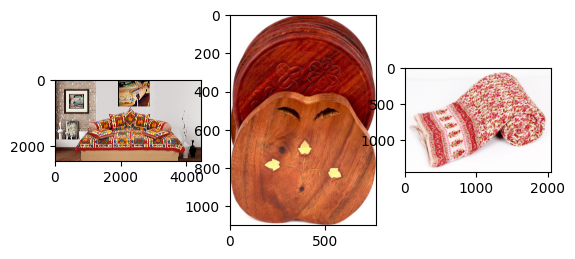

Baby Care


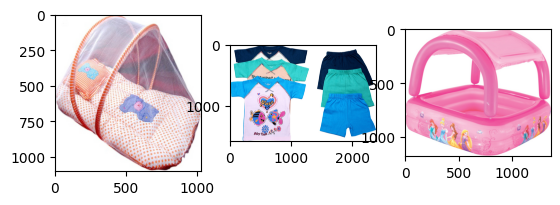

Wrist Watches


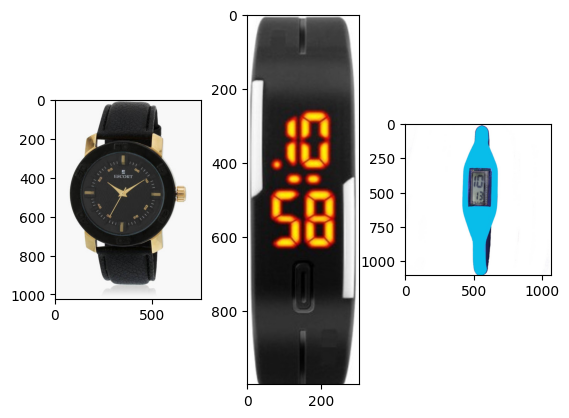

Festive Needs


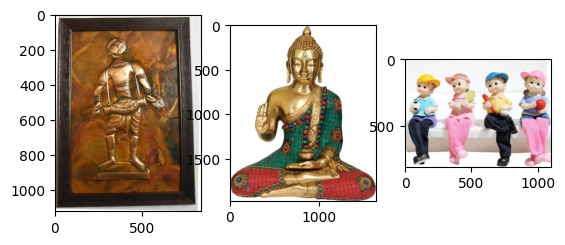

Tray Sets


IndexError: list index out of range

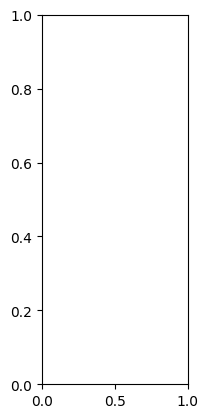

In [34]:
# plot images par catégories

from matplotlib.image import imread

def list_fct(name):
    list_image_name = [data['image_path'][i] for i in range(len(data)) if data['category'][i] == name]
    return list_image_name

for name in list_labels:
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [37]:
##### étape 1 : étude de faisabilité
# ## Création du modèle pré-entraîné

base_model = VGG16()
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 26s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [38]:
# création des features des images

images_features = []
i = 0
for image_file in data['image_path']:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size = (224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose = 0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

In [39]:
# réduction dimension et analyse
# acp

from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [40]:
# tsne

from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print('temps de T-SNE : ', '%15.2f' % duration1, 'secondes')

temps de T-SNE :             4.39 secondes


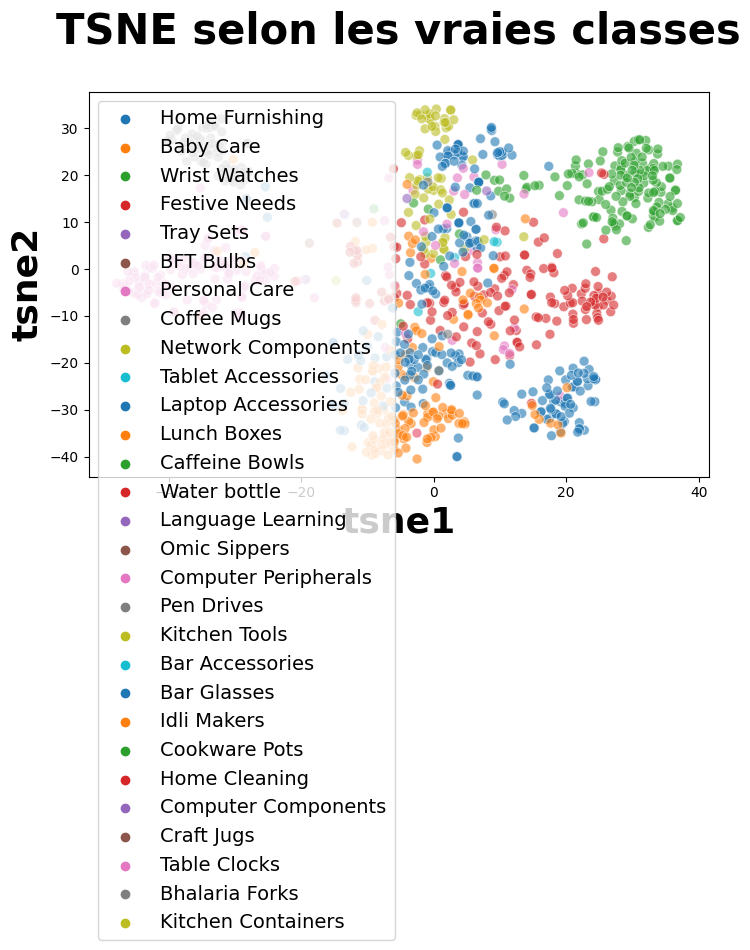

In [42]:
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = data['category']

plt.figure(figsize = (8, 5))
sns.scatterplot(
    x = 'tsne1',
    y = 'tsne2',
    hue = 'class',
    palette = sns.color_palette('tab10', n_colors = 30),
    s = 50,
    alpha = 0.6,
    data = df_tsne,
    legend = 'brief'
    )

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

In [43]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters = 30, n_init = 100)
cls.fit(X_tsne)

KMeans(n_clusters=30, n_init=100)

In [48]:
df_tsne["cluster"] = cls.labels_
df_tsne["cluster"]

0       17
1       10
2        0
3        9
4        9
        ..
1045    17
1046    13
1047    13
1048    13
1049    13
Name: cluster, Length: 1050, dtype: int32

In [49]:
labels = data["category"]
labels

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1050, dtype: object

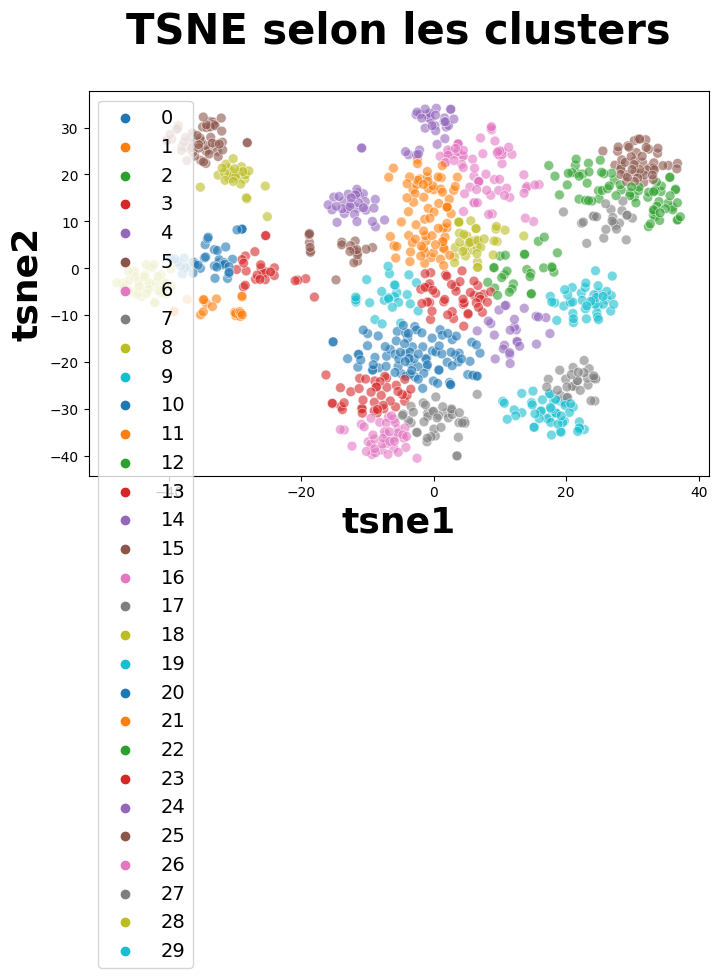

ValueError: Input contains NaN.

In [50]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize = (8,5))
sns.scatterplot(
    x = "tsne1",
    y = "tsne2",
    hue = "cluster",
    palette = sns.color_palette('tab10', n_colors = 30),
    s = 50,
    alpha = 0.6,
    data = df_tsne,
    legend = "brief"
    )

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

labels = data["category_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [45]:
# Analyse d'image "shine" affectées au cluster 3 "cloudy"

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['category'] == 'Home Furnishing') and (df_tsne.iloc[i]['cluster'] == 0)]
list_shine_0[0]

439

tsne1        3.00529
tsne2     -10.737918
class      Baby Care
cluster           13
Name: 220, dtype: object


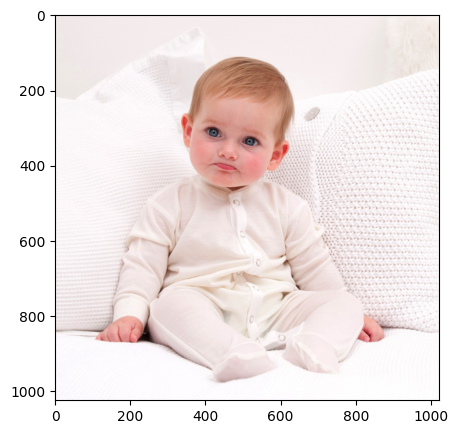

In [46]:
# Affichage image "shine" considérée comme "cloudy"
id = 220
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

In [51]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

ValueError: Input y_true contains NaN.

In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis = 0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name = "y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot = True, cmap = "Blues")

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation = 'softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs = model0.input, outputs = predictions)
    # compilation du modèle 
    model.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics = ["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

In [ ]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 42)
X_train.shape

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(
        X_train,
        y_train,
        epochs = 50,
        batch_size = 64,
        callbacks = callbacks_list,
        validation_data = (X_val, y_val),
        verbose = 1
        )

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose = True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose = True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose = False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose = False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path = "standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis = 1)
y_val_pred = np.argmax(model1.predict(X_val), axis = 1)
y_val_num = np.argmax(y_val, axis = 1)
print(y_val_num)
print()
print(y_val_pred)

In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot = True, cmap = "Blues")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pour mélanger les images, classées initalement par classe
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type = None) :
    data_flow = datagen.flow_from_dataframe(data, directory = '',
                                x_col = 'image_path', y_col = 'label_name',
                                weight_col = None, target_size = (256, 256),
                                classes = None, class_mode = 'categorical',
                                batch_size = batch_size, shuffle = True, seed = 42,
                                subset = data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.25,
    preprocessing_function = preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type = 'training')
val_flow = data_flow_fct(data, datagen_train, data_type = 'validation')

datagen_test = ImageDataGenerator(
    validation_split = 0,
    preprocessing_function = preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type = None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(
        train_flow,
        validation_data = val_flow,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose = True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose = True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose = False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose = False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path = "standard.png")
plt.close()

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split = 0, data_type = None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels = 'inferred', label_mode = 'categorical',
                    class_names = None, batch_size = 32, image_size = (224, 224), shuffle = True, seed = 42,
                    validation_split = validation_split, subset = data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split = 0.25, data_type = 'training')
dataset_val = dataset_fct(path, validation_split = 0.25, data_type = 'validation')
dataset_test = dataset_fct(path_test, validation_split = 0, data_type = None)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data = dataset_val,
                    batch_size = batch_size, epochs = 50, callbacks = callbacks_list, verbose = 1)

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose = True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose = True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose = False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose = False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path = "standard.png")
plt.close()

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split = 0, data_type = None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels = 'inferred', label_mode = 'categorical',
                    class_names = None, batch_size = batch_size, image_size = (224, 224), shuffle = True, seed = 42,
                    validation_split = validation_split, subset = data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split = 0.25, data_type = 'training')
dataset_val = dataset_fct(path, validation_split = 0.25, data_type = 'validation')
dataset_test = dataset_fct(path_test, validation_split = 0, data_type = None)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape = (224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset = -1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation = 'relu'),
                Dropout(0.5),
                Dense(4, activation = 'softmax')
                ])

    # compilation du modèle 
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])

    print(model.summary())
    
    return model

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data = dataset_val,
                    batch_size = batch_size, epochs = 50, callbacks = callbacks_list, verbose = 1)

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose = True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose = True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose = False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose = False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path = "standard.png")
plt.close()